In [1]:
import os
import random

from PIL import Image

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_data

2024-04-13 11:49:03.383882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
python(66677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


## Load Data

In [2]:
PATH_TO_TRAINING_DATA = 'data/train/'
PATH_TO_VALID_DATA = 'data/valid/'
PATH_TO_TEST_DATA = 'data/test/'

In [6]:
%%time

X_train, y_train = load_data(PATH_TO_TRAINING_DATA)
print("Shape of training images ", X_train.shape)
print("Shape of training labels ", y_train.shape)

X_val, y_val = load_data(PATH_TO_VALID_DATA)
print("Shape of validation images ", X_val.shape)
print("Shape of validation labels ", y_val.shape)

X_test, y_test = load_data(PATH_TO_TEST_DATA)
print("Shape of test images ", X_test.shape)
print("Shape of test labels ", y_test.shape)

3 images failed to load.
Shape of training images  (30249, 50, 50, 3)
Shape of training labels  (30249,)
2 images failed to load.
Shape of validation images  (6300, 50, 50, 3)
Shape of validation labels  (6300,)
3 images failed to load.
Shape of test images  (6299, 50, 50, 3)
Shape of test labels  (6299,)
CPU times: user 5min, sys: 30.8 s, total: 5min 30s
Wall time: 5min 39s


## Data Reshape

In [9]:
# The labels need to be converted to integers from strings
y_train = np.where(y_train == 'wildfire', 1, 0)
y_val = np.where(y_val == 'wildfire', 1, 0)
y_test = np.where(y_test == 'wildfire', 1, 0)

## Model

In [ ]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True
)

In [17]:
# Load pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the pre-trained ResNet50
model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24112513 (91.98 MB)
Trainable params: 524801 (2.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
epochs = range(10)
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

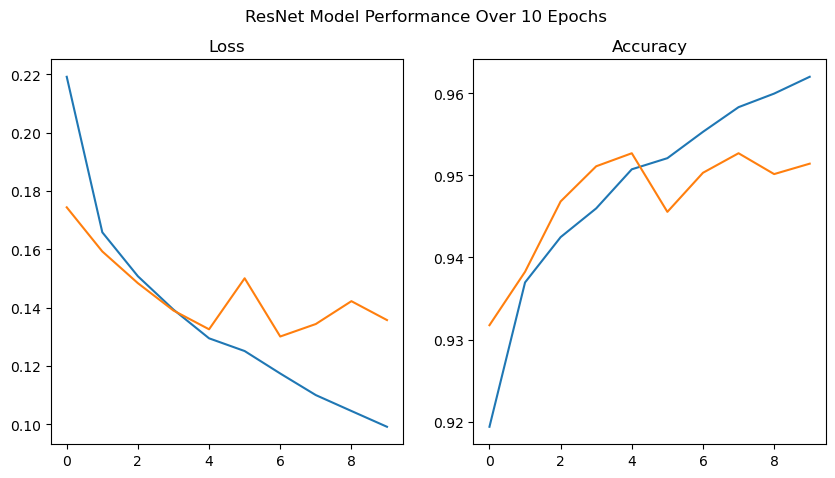

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('ResNet Model Performance Over 10 Epochs')

axs[0].plot(epochs, loss)
axs[0].plot(epochs, val_loss)
axs[0].title.set_text('Loss')

axs[1].plot(epochs, accuracy)
axs[1].plot(epochs, val_accuracy)
axs[1].title.set_text('Accuracy')

On validation accuracy > training accuracy (https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models#:~:text=When%20the%20validation%20accuracy%20is,reducing%20the%20bias%20and%20variance.):

"@Saket Chachurvedi By looking at the plots, I think nothing wrong with the model. We can't say model is over fitted because there is no big gap between train accuracy vs validation accuracy. In fact after some epochs model converges to a point where train and validation accuracies are almost equal.If you didn't notice that trend while you were experimenting, then it may be because of data. The potential reasons could be
1. Train data is huge and very small data used for testing. Try to shuffle the data and increase the test data
2. It may be because of data imbalance. If your data is multi class then try to use categorical cross entropy as your loss function and report F1 measure so that you will be knowing whether model is biased towards one class.
3. Try to remove some dropout layers in the model so that all the neurons contribute equally on train data as well as validation data. If you are worrying about over-fitting try to add regularizers and reduce hidden neurons in the fully connected layers."

## Assess Model Performance

In [39]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train)
val_loss, val_acc = model.evaluate(X_val, y_val)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Train accuracy:', train_acc)
print('Validation accuracy:', val_acc)
print('Test accuracy:', test_acc)

197/197 [==============================] - 48s 243ms/step - loss: 0.1165 - accuracy: 0.9608
Train accuracy: 0.9773215651512146
Validation accuracy: 0.9514285922050476
Test accuracy: 0.9607874155044556


197/197 [==============================] - 40s 203ms/step


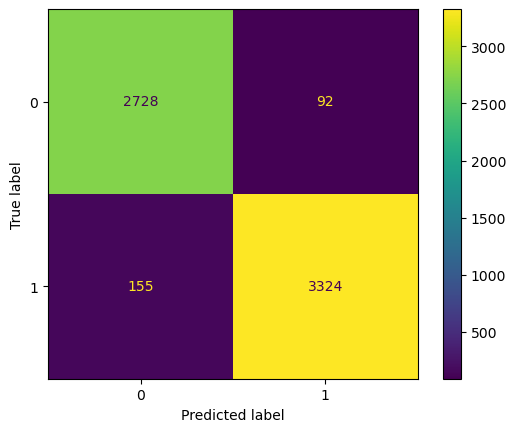

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predictions = model.predict(X_test)
test_predictions = np.where(test_predictions >= 0.5, 1, 0)

cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()